In [7]:
Tmp = ['Test001', 'Test002', 'Test003']
Tmp[2][-1]

'3'

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage
import skimage.exposure
import mahotas as mh
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from dual_IDG import DualImageDataGenerator

Using TensorFlow backend.


In [10]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, \
    Lambda, UpSampling2D, Cropping2D, Concatenate
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [11]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.3.1
TensorFlow version: 2.0.0


In [12]:
K.set_image_data_format('channels_first')

In [8]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [9]:
def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [10]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

# 提取sample_data数据

256 256
256 (256, 256, 3) 256
52266_04_F2_LE_LS


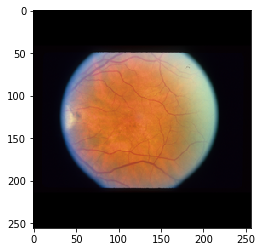

In [22]:
import os
from platform import python_version_tuple

if python_version_tuple()[0] == 3:
    xrange = range

import numpy as np
import pandas as pd
import cv2
import imhandle as imh

def extract_sample_data(db_folder):
    result_resolution = (256, 256)
#     image_path = db_folder
    X, file_names = imh.load_set(os.path.join(db_folder, 'sample_data'))
    rel_file_names = [os.path.split(fn)[-1] for fn in file_names]
    file_codes = [fn[:fn.rfind('.')] for fn in rel_file_names]
    for i in range(len(X)):
#         L_R_mark = file_codes[i][-5]
        side = result_resolution[0]
#         if L_R_mark == 'L':
        
        X[i] = imh.resize_image_to_square(X[i], side, pad_cval=0)
    return X, file_codes
X, file_codes = extract_sample_data(os.path.join(os.getcwd(), 'data'))
print(len(X), len(file_codes))
print(len(X), X[0].shape, len(file_codes))
print(file_codes[0])
plt.imshow(X[0])
plt.show()

In [23]:
X


[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 

# 导入数据

In [11]:
h5f = h5py.File(os.path.join(os.getcwd(), 'data',  'RIM_ONE_v3.hdf5'), 'r')

In [12]:
X = h5f['RIM-ONE v3/256 px/images']
Y = h5f['RIM-ONE v3/256 px/disc']

In [13]:
X, Y

(<HDF5 dataset "images": shape (159, 256, 256, 3), type "|u1">,
 <HDF5 dataset "disc": shape (159, 256, 256, 1), type "|u1">)

# 将数据集分割成训练集和测试集 

In [13]:
train_idx_cv, test_idx_cv = [], []

for _train_idx, _test_idx in KFold(n_splits=5,shuffle=True, random_state=1).split(X):
    print(_train_idx, _test_idx)
    train_idx_cv.append(_train_idx)
    test_idx_cv.append(_test_idx)

[  0   1   2   3   4   6   7   8   9  10  12  13  15  17  18  20  21  22
  23  24  25  26  27  28  30  32  33  34  36  37  38  39  41  43  45  46
  47  48  49  50  52  53  55  56  57  58  60  61  62  63  64  65  67  68
  69  70  71  72  74  75  76  77  78  79  80  82  83  85  86  87  88  92
  95  96  98  99 101 102 104 106 107 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 144 146 147 148 149 150 151 152 154 155 156 157
 158] [  5  11  14  16  19  29  31  35  40  42  44  51  54  59  66  73  81  84
  89  90  91  93  94  97 100 103 105 108 127 143 145 153]
[  0   1   2   3   5   6   7   8   9  10  11  14  15  16  19  20  21  22
  23  24  25  26  27  29  30  31  32  34  35  37  38  40  41  42  43  44
  46  49  50  51  52  54  55  57  59  60  61  62  63  64  65  66  67  68
  70  71  72  73  74  76  79  80  81  82  83  84  85  86  87  88  89  90
  91  93  94  95  96  97  98  99 100 101 103 104 105 107 108

In [14]:
#train_idx = h5f['RIM-ONE v3/train_idx_driu']
#test_idx = h5f['RIM-ONE v3/test_idx_driu']

train_idx = train_idx_cv[0]
test_idx = test_idx_cv[0]

In [15]:
print(train_idx)

[  0   1   2   3   4   6   7   8   9  10  12  13  15  17  18  20  21  22
  23  24  25  26  27  28  30  32  33  34  36  37  38  39  41  43  45  46
  47  48  49  50  52  53  55  56  57  58  60  61  62  63  64  65  67  68
  69  70  71  72  74  75  76  77  78  79  80  82  83  85  86  87  88  92
  95  96  98  99 101 102 104 106 107 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 144 146 147 148 149 150 151 152 154 155 156 157
 158]


In [17]:
len(X), len(train_idx), len(test_idx)

(159, 127, 32)

In [18]:
train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=50, width_shift_range=0.15, height_shift_range=0.15,
                                   zoom_range=(0.7, 1.3),
                                   fill_mode='constant', cval=0.0)
test_idg = DualImageDataGenerator()

In [19]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    batch_y = batch_y / 255.0
    if train_or_test == 'train':
        batch_X, batch_y = next(train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    elif train_or_test == 'test':
        batch_X, batch_y = next(test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i]) 
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, train_or_test='train', batch_size=3, return_orig=False, stationary=False):    
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)
        batch_X = [X[i] for i in idx]
        batch_X = np.array(batch_X).copy()
        batch_y = [y[i] for i in idx]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
        
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

In [20]:
gen = data_generator(X, Y, 'train', batch_size=1)
batch = next(gen)
batch[0].shape

(1, 3, 256, 256)

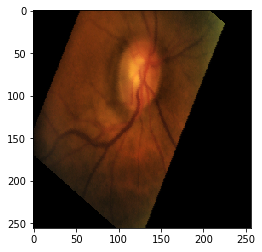

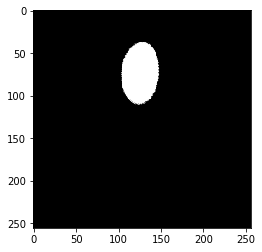

In [21]:
fig = plt.imshow(np.rollaxis(batch[0][0], 0, 3))
#plt.colorbar(mappable=fig)
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.show()

In [22]:
arch_name = "U-Net light on RIM-ONE v3"
weights_folder = os.path.join(os.getcwd(), 'models_weights', arch_name)
print(weights_folder)

/home/lhm/optic_disc/models_weights/U-Net light on RIM-ONE v3


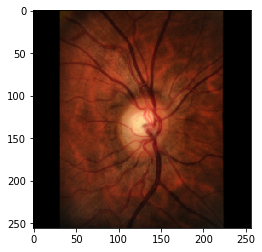

(32, 3, 256, 256) (32, 1, 256, 256)


In [23]:
X_valid, Y_valid = next(data_generator(X, Y, train_or_test='test', batch_size=100, stationary=True))
plt.imshow(np.rollaxis(X_valid[0], 0, 3)); plt.show()
print(X_valid.shape, Y_valid.shape)

In [14]:
def get_unet_light(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [15]:
model = get_unet_light(img_rows=256, img_cols=256)
model.compile(optimizer=SGD(lr=1e-3, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 256, 256)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 256, 256) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 256, 256) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 256, 256) 9248        dropout_1[0][0]                  
____________________________________________________________________________________________

In [27]:
history = model.fit(data_generator(X, Y, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,
                              
                              validation_data=(X_valid, Y_valid),
                              #validation_data=data_generator(X, Y, train_or_test='test', batch_size=1),
                              #nb_val_samples=100,
                              
                              epochs=400, verbose=1,
                              
                              callbacks=[CSVLogger(os.path.join(weights_folder, 'training_log.csv')),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=40),
                                         ModelCheckpoint(os.path.join(weights_folder,
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

Epoch 1/400
99/99 [==============================] - 54s 546ms/step - loss: 1.5159 - mean_IOU_gpu: 0.2316 - dice_metric: 0.3302 - val_loss: 0.5414 - val_mean_IOU_gpu: 0.4209 - val_dice_metric: 0.5708
Epoch 2/400
99/99 [==============================] - 52s 528ms/step - loss: 0.5694 - mean_IOU_gpu: 0.4446 - dice_metric: 0.5846 - val_loss: 0.3333 - val_mean_IOU_gpu: 0.5348 - val_dice_metric: 0.6869
Epoch 3/400
99/99 [==============================] - 52s 522ms/step - loss: 0.3823 - mean_IOU_gpu: 0.5203 - dice_metric: 0.6600 - val_loss: 0.5561 - val_mean_IOU_gpu: 0.3912 - val_dice_metric: 0.5363
Epoch 4/400
99/99 [==============================] - 51s 518ms/step - loss: 0.3501 - mean_IOU_gpu: 0.5328 - dice_metric: 0.6733 - val_loss: 0.5110 - val_mean_IOU_gpu: 0.3797 - val_dice_metric: 0.5205
Epoch 5/400
99/99 [==============================] - 52s 522ms/step - loss: 0.3681 - mean_IOU_gpu: 0.5074 - dice_metric: 0.6538 - val_loss: 0.4051 - val_mean_IOU_gpu: 0.4751 - val_dice_metric: 0.6163


Epoch 42/400
99/99 [==============================] - 51s 513ms/step - loss: 0.2339 - mean_IOU_gpu: 0.6454 - dice_metric: 0.7671 - val_loss: 0.1309 - val_mean_IOU_gpu: 0.7768 - val_dice_metric: 0.8627
Epoch 43/400
99/99 [==============================] - 51s 512ms/step - loss: 0.1732 - mean_IOU_gpu: 0.6882 - dice_metric: 0.8048 - val_loss: 0.1457 - val_mean_IOU_gpu: 0.7340 - val_dice_metric: 0.8350
Epoch 44/400
99/99 [==============================] - 51s 519ms/step - loss: 0.1607 - mean_IOU_gpu: 0.7103 - dice_metric: 0.8216 - val_loss: 0.1569 - val_mean_IOU_gpu: 0.7300 - val_dice_metric: 0.8319
Epoch 45/400
99/99 [==============================] - 51s 513ms/step - loss: 0.1526 - mean_IOU_gpu: 0.7199 - dice_metric: 0.8276 - val_loss: 0.1914 - val_mean_IOU_gpu: 0.7000 - val_dice_metric: 0.8084
Epoch 46/400
99/99 [==============================] - 51s 517ms/step - loss: 0.1979 - mean_IOU_gpu: 0.6949 - dice_metric: 0.8012 - val_loss: 0.1635 - val_mean_IOU_gpu: 0.6975 - val_dice_metric: 0.

Epoch 83/400
99/99 [==============================] - 51s 516ms/step - loss: 0.1325 - mean_IOU_gpu: 0.7358 - dice_metric: 0.8406 - val_loss: 0.1016 - val_mean_IOU_gpu: 0.7948 - val_dice_metric: 0.8780
Epoch 84/400
99/99 [==============================] - 51s 511ms/step - loss: 0.1468 - mean_IOU_gpu: 0.7276 - dice_metric: 0.8313 - val_loss: 0.1115 - val_mean_IOU_gpu: 0.7879 - val_dice_metric: 0.8741
Epoch 85/400
99/99 [==============================] - 51s 517ms/step - loss: 0.1497 - mean_IOU_gpu: 0.7194 - dice_metric: 0.8289 - val_loss: 0.2235 - val_mean_IOU_gpu: 0.6403 - val_dice_metric: 0.7623
Epoch 86/400
99/99 [==============================] - 52s 521ms/step - loss: 0.1285 - mean_IOU_gpu: 0.7467 - dice_metric: 0.8463 - val_loss: 0.1688 - val_mean_IOU_gpu: 0.7184 - val_dice_metric: 0.8203
Epoch 87/400
99/99 [==============================] - 51s 516ms/step - loss: 0.1101 - mean_IOU_gpu: 0.7590 - dice_metric: 0.8592 - val_loss: 0.1338 - val_mean_IOU_gpu: 0.7731 - val_dice_metric: 0.

Epoch 124/400
99/99 [==============================] - 52s 524ms/step - loss: 0.0819 - mean_IOU_gpu: 0.8050 - dice_metric: 0.8895 - val_loss: 0.0943 - val_mean_IOU_gpu: 0.8025 - val_dice_metric: 0.8814
Epoch 125/400
99/99 [==============================] - 51s 518ms/step - loss: 0.0860 - mean_IOU_gpu: 0.8002 - dice_metric: 0.8856 - val_loss: 0.1006 - val_mean_IOU_gpu: 0.7879 - val_dice_metric: 0.8710
Epoch 126/400
99/99 [==============================] - 52s 525ms/step - loss: 0.0871 - mean_IOU_gpu: 0.7988 - dice_metric: 0.8845 - val_loss: 0.1457 - val_mean_IOU_gpu: 0.7651 - val_dice_metric: 0.8492
Epoch 127/400
99/99 [==============================] - 52s 524ms/step - loss: 0.0878 - mean_IOU_gpu: 0.8003 - dice_metric: 0.8851 - val_loss: 0.1150 - val_mean_IOU_gpu: 0.7819 - val_dice_metric: 0.8643
Epoch 128/400
99/99 [==============================] - 52s 529ms/step - loss: 0.0788 - mean_IOU_gpu: 0.8098 - dice_metric: 0.8926 - val_loss: 0.1406 - val_mean_IOU_gpu: 0.7485 - val_dice_metri

Epoch 205/400
99/99 [==============================] - 51s 520ms/step - loss: 0.0610 - mean_IOU_gpu: 0.8447 - dice_metric: 0.9142 - val_loss: 0.0671 - val_mean_IOU_gpu: 0.8473 - val_dice_metric: 0.9123
Epoch 206/400
99/99 [==============================] - 51s 519ms/step - loss: 0.0688 - mean_IOU_gpu: 0.8290 - dice_metric: 0.9041 - val_loss: 0.0639 - val_mean_IOU_gpu: 0.8439 - val_dice_metric: 0.9117
Epoch 207/400
99/99 [==============================] - 51s 517ms/step - loss: 0.0734 - mean_IOU_gpu: 0.8248 - dice_metric: 0.9010 - val_loss: 0.0639 - val_mean_IOU_gpu: 0.8461 - val_dice_metric: 0.9119
Epoch 208/400
99/99 [==============================] - 51s 518ms/step - loss: 0.0560 - mean_IOU_gpu: 0.8503 - dice_metric: 0.9178 - val_loss: 0.0653 - val_mean_IOU_gpu: 0.8388 - val_dice_metric: 0.9091
Epoch 209/400
99/99 [==============================] - 51s 511ms/step - loss: 0.0587 - mean_IOU_gpu: 0.8468 - dice_metric: 0.9157 - val_loss: 0.0612 - val_mean_IOU_gpu: 0.8484 - val_dice_metri

Epoch 286/400
99/99 [==============================] - 51s 513ms/step - loss: 0.0525 - mean_IOU_gpu: 0.8589 - dice_metric: 0.9226 - val_loss: 0.0682 - val_mean_IOU_gpu: 0.8318 - val_dice_metric: 0.9064
Epoch 287/400
99/99 [==============================] - 51s 517ms/step - loss: 0.0440 - mean_IOU_gpu: 0.8735 - dice_metric: 0.9317 - val_loss: 0.0631 - val_mean_IOU_gpu: 0.8490 - val_dice_metric: 0.9147
Epoch 288/400
99/99 [==============================] - 51s 515ms/step - loss: 0.0475 - mean_IOU_gpu: 0.8677 - dice_metric: 0.9282 - val_loss: 0.0699 - val_mean_IOU_gpu: 0.8433 - val_dice_metric: 0.9102
Epoch 289/400
99/99 [==============================] - 51s 516ms/step - loss: 0.0452 - mean_IOU_gpu: 0.8713 - dice_metric: 0.9306 - val_loss: 0.1105 - val_mean_IOU_gpu: 0.8260 - val_dice_metric: 0.8901
Epoch 290/400
99/99 [==============================] - 51s 517ms/step - loss: 0.0446 - mean_IOU_gpu: 0.8742 - dice_metric: 0.9320 - val_loss: 0.0934 - val_mean_IOU_gpu: 0.8148 - val_dice_metri

Epoch 367/400
99/99 [==============================] - 51s 517ms/step - loss: 0.0438 - mean_IOU_gpu: 0.8748 - dice_metric: 0.9324 - val_loss: 0.0566 - val_mean_IOU_gpu: 0.8539 - val_dice_metric: 0.9190
Epoch 368/400
99/99 [==============================] - 51s 515ms/step - loss: 0.0437 - mean_IOU_gpu: 0.8746 - dice_metric: 0.9324 - val_loss: 0.0428 - val_mean_IOU_gpu: 0.8832 - val_dice_metric: 0.9362
Epoch 369/400
99/99 [==============================] - 52s 520ms/step - loss: 0.0432 - mean_IOU_gpu: 0.8768 - dice_metric: 0.9336 - val_loss: 0.0457 - val_mean_IOU_gpu: 0.8760 - val_dice_metric: 0.9324
Epoch 370/400
99/99 [==============================] - 51s 518ms/step - loss: 0.0432 - mean_IOU_gpu: 0.8761 - dice_metric: 0.9331 - val_loss: 0.0664 - val_mean_IOU_gpu: 0.8468 - val_dice_metric: 0.9122
Epoch 371/400
99/99 [==============================] - 51s 515ms/step - loss: 0.0403 - mean_IOU_gpu: 0.8830 - dice_metric: 0.9373 - val_loss: 0.0702 - val_mean_IOU_gpu: 0.8560 - val_dice_metri

image #5


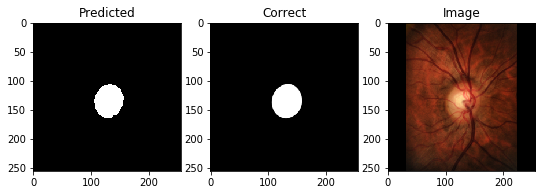

IOU: 0.9109393954277039
Dice: 0.9593785950168394
image #11


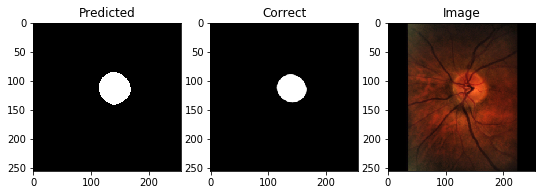

IOU: 0.8072186708450317
Dice: 0.9001773908298195
image #14


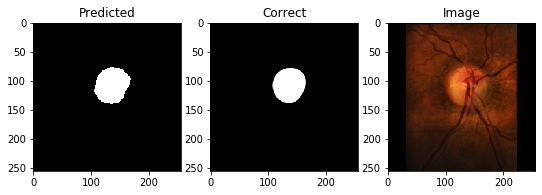

IOU: 0.9047459959983826
Dice: 0.9566827384501086
image #16


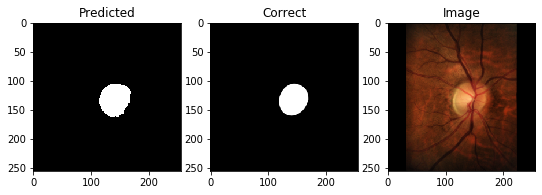

IOU: 0.8396302461624146
Dice: 0.9201341739637035
image #19


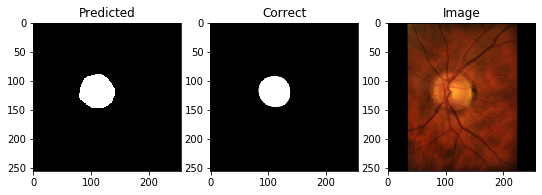

IOU: 0.8316866755485535
Dice: 0.915317280231131
image #29


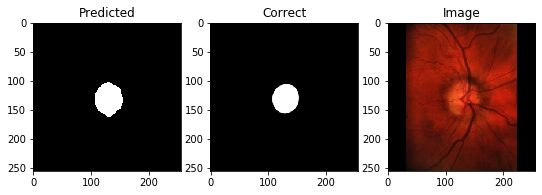

IOU: 0.8482308983802795
Dice: 0.9268500944191027
image #31


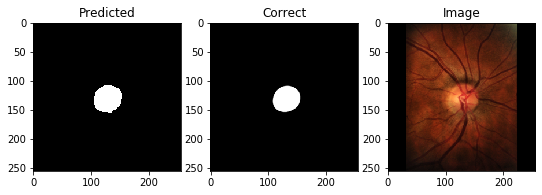

IOU: 0.8500788807868958
Dice: 0.9266890965464951
image #35


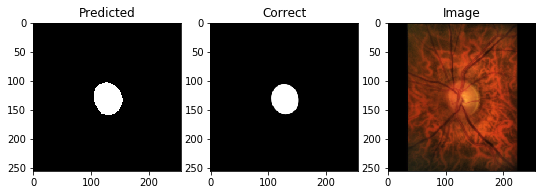

IOU: 0.880692183971405
Dice: 0.9439120993031473
image #40


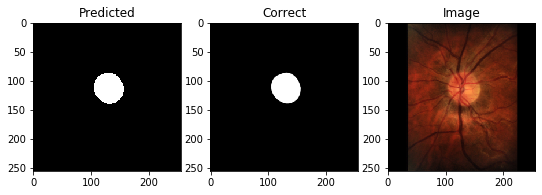

IOU: 0.960405170917511
Dice: 0.9847344614708201
image #42


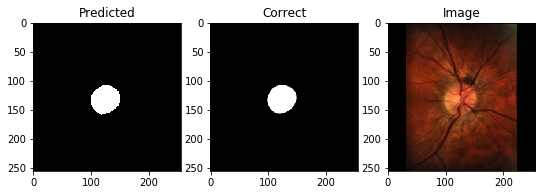

IOU: 0.9279323816299438
Dice: 0.9692142780960041
image #44


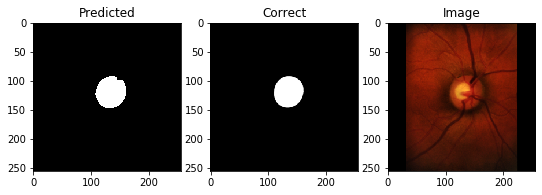

IOU: 0.926148533821106
Dice: 0.9679879075282034
image #51


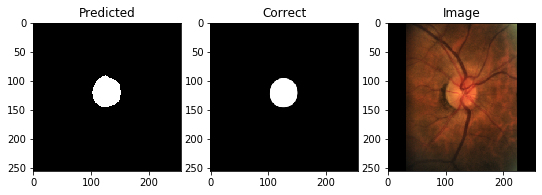

IOU: 0.9092645645141602
Dice: 0.9602637908232226
image #54


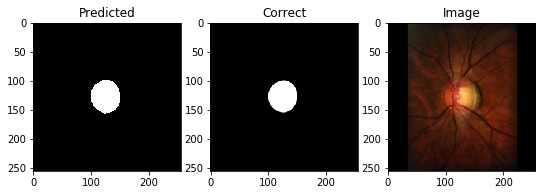

IOU: 0.9290043115615845
Dice: 0.9717151268789561
image #59


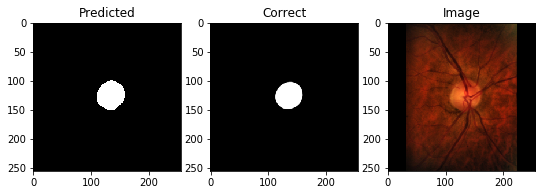

IOU: 0.862915575504303
Dice: 0.9327305834472178
image #66


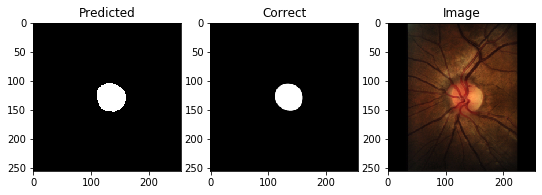

IOU: 0.8794220089912415
Dice: 0.9438830750474105
image #73


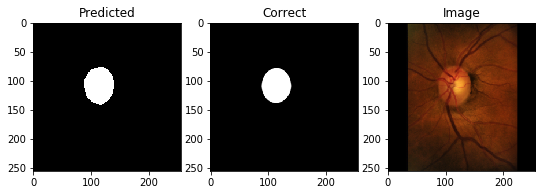

IOU: 0.9068440794944763
Dice: 0.959635026492761
image #81


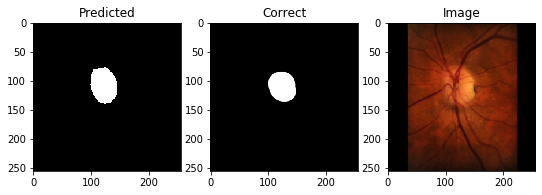

IOU: 0.783603847026825
Dice: 0.8848509543764782
image #84


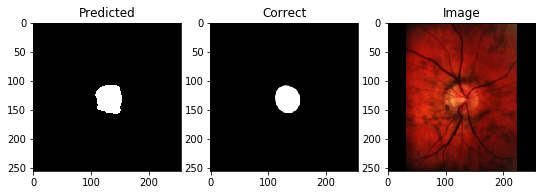

IOU: 0.8165802955627441
Dice: 0.9054856930808162
image #89


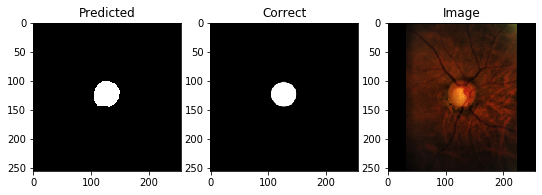

IOU: 0.8974999785423279
Dice: 0.9534622610029853
image #90


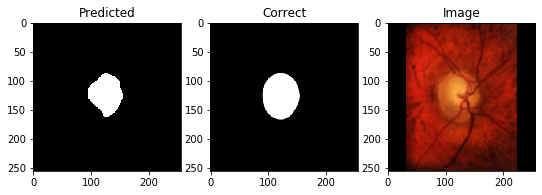

IOU: 0.7611607313156128
Dice: 0.8692987925358989
image #91


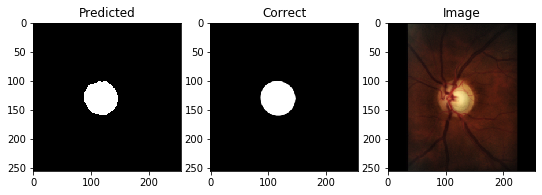

IOU: 0.939957857131958
Dice: 0.9761388543751396
image #93


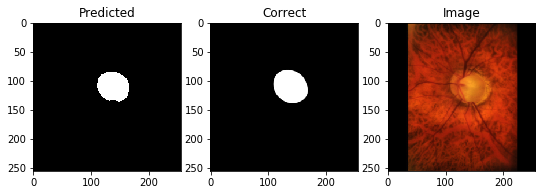

IOU: 0.8535031676292419
Dice: 0.9288630659523022
image #94


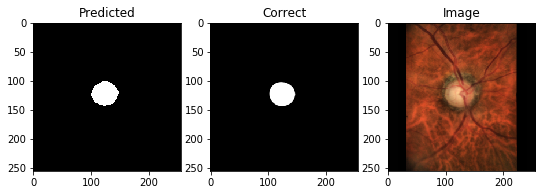

IOU: 0.9246889352798462
Dice: 0.9690145398388477
image #97


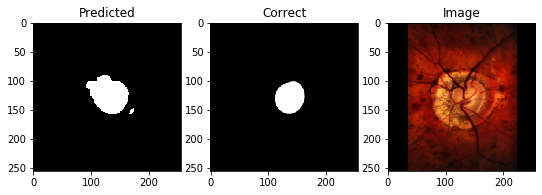

IOU: 0.6396760940551758
Dice: 0.7872442293418621
image #100


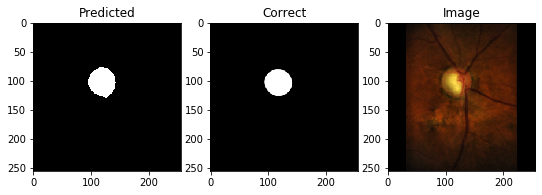

IOU: 0.8670490384101868
Dice: 0.9369254278945124
image #103


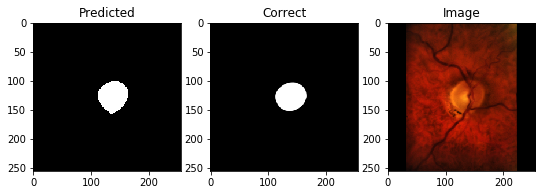

IOU: 0.8766146898269653
Dice: 0.9415462845685199
image #105


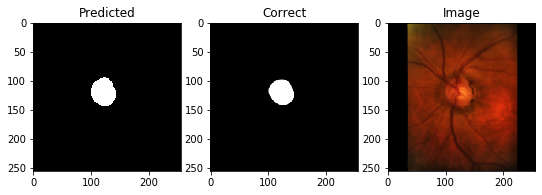

IOU: 0.8480189442634583
Dice: 0.9283045401806506
image #108


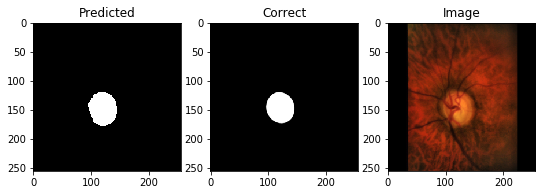

IOU: 0.8900132179260254
Dice: 0.9492383976659603
image #127


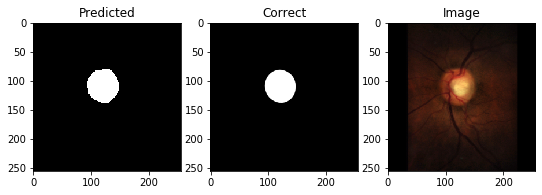

IOU: 0.9369582533836365
Dice: 0.9722148750207688
image #143


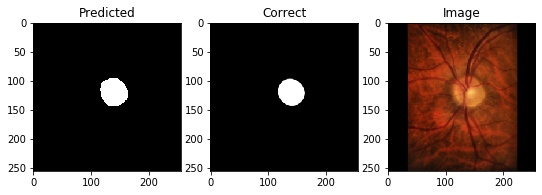

IOU: 0.9063180685043335
Dice: 0.9588736954496949
image #145


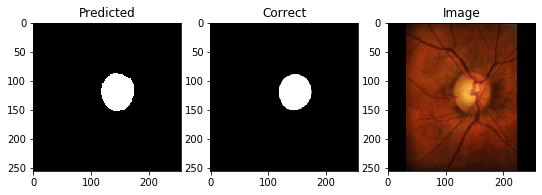

IOU: 0.9261517524719238
Dice: 0.9672603615533067
image #153


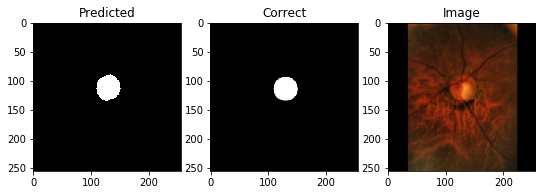

IOU: 0.8700265288352966
Dice: 0.9384321085383475


In [28]:
pred_iou, pred_dice = [], []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = X[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    # mean filtering:
    #pred = mh.mean_filter(pred, Bc=mh.disk(10)) > 0.5
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

In [29]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.8722807
0.9377018687475324


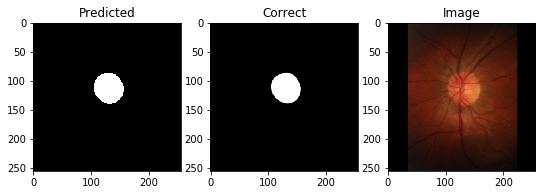

IOU: 0.960405170917511, Dice: 0.9847344614708201 (best)


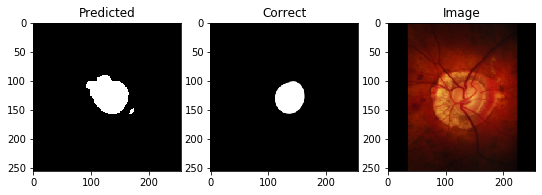

IOU: 0.6396760940551758, Dice: 0.7872442293418621 (worst)


In [30]:
def show_img_pred_corr(i, file_suffix):    # i is index of image in test_idx
    img_no = test_idx[i]
    batch_X = X[img_no:img_no + 1]
    batch_X = tf_to_th_encoding(batch_X)
    batch_y = Y[img_no:img_no + 1]
    batch_y = tf_to_th_encoding(batch_y)
    batch_X, batch_y = preprocess(batch_X, batch_y, 'test')
    
    pred = model.predict(batch_X)[0, 0] > 0.5
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(X[img_no])
    ax.set_title('Image')
    plt.show()
    
    plt.imsave('od_rim_one_v3_fold_0_{}_case_image.png'.format(file_suffix), X[img_no])
    plt.imsave('od_rim_one_v3_fold_0_{}_case_pred.png'.format(file_suffix), pred, cmap=plt.cm.Greys_r)
    plt.imsave('od_rim_one_v3_fold_0_{}_case_corr.png'.format(file_suffix), corr, cmap=plt.cm.Greys_r)


best_idx = np.argmax(pred_iou)
worst_idx = np.argmin(pred_iou)
show_img_pred_corr(best_idx, 'best')
print('IOU: {}, Dice: {} (best)'.format(pred_iou[best_idx], pred_dice[best_idx]))
show_img_pred_corr(worst_idx, 'worst')
print('IOU: {}, Dice: {} (worst)'.format(pred_iou[worst_idx], pred_dice[worst_idx]))

In [16]:
load_model = True   # lock
if not load_model:
    print('load_model == False')
else:
    # UNCOMMENT APPROPRIATE LINE(S) BELOW:
    # specify file:
    #model_path = '../models_weights/01.11,22:38,U-Net on DRIONS-DB 256 px, Adam, augm, log_dice loss/' \
    #    'weights.ep-20-val_mean_IOU-0.81_val_loss_0.08.hdf5'
    # or get the most recently altered file in a folder:
    model_folder = os.path.join(os.getcwd(), 'models_weights', 'U-Net light on RIM-ONE v3')
    
    model_path = max(glob.glob(os.path.join(model_folder, '*.hdf5')), key=os.path.getctime)
    if load_model and not os.path.exists(model_path):
        raise Exception('`model_path` does not exist')
    print('Loading weights from', model_path)

    if load_model:
        #with open(model_path + ' arch.json') as arch_file:
        #    json_string = arch_file.read()
        #new_model = model_from_json(json_string)
        model.load_weights(model_path)
    
    # Reading log statistics
    import pandas as pd
    
    log_path = os.path.join(model_folder, 'training_log.csv')
    if os.path.exists(log_path):
        log = pd.read_csv(log_path)
        if log['epoch'].dtype != 'int64':
            log = log.loc[log.epoch != 'epoch']
        print('\nmax val mean IOU: {}, at row:'.format(log['val_mean_IOU_gpu'].max()))
        print(log.loc[log['val_mean_IOU_gpu'].idxmax()])
        if 'val_dice_metric' in log.columns:
            print('\n' + 'max val dice_metric: {}, at row:'.format(log['val_dice_metric'].max()))
            print(log.loc[log['val_dice_metric'].idxmax()])
        if 'val_dice' in log.columns:
            print('\n' + 'max val dice: {}, at row:'.format(log['val_dice'].max()))
            print(log.loc[log['val_dice'].idxmax()])

Loading weights from /home/lhm/optic_disc/models_weights/U-Net light on RIM-ONE v3/last_checkpoint.hdf5

max val mean IOU: 0.8831598162651062, at row:
epoch               367.000000
dice_metric           0.932425
loss                  0.043670
mean_IOU_gpu          0.874642
val_dice_metric       0.936156
val_loss              0.042802
val_mean_IOU_gpu      0.883160
Name: 367, dtype: float64

max val dice_metric: 0.9361556768417358, at row:
epoch               367.000000
dice_metric           0.932425
loss                  0.043670
mean_IOU_gpu          0.874642
val_dice_metric       0.936156
val_loss              0.042802
val_mean_IOU_gpu      0.883160
Name: 367, dtype: float64
